In [1]:
import tensorflow as tf
import tensorflow.contrib as tcb
import numpy as np

[[   4    1]
 [   5    2]
 [   6   17]
 ..., 
 [2304    1]
 [2850    1]
 [3080    1]]


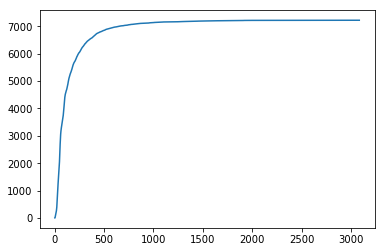

6851

In [2]:
tcb.rnn.LSTMCell
cell = tcb.rnn.LSTMCell(num_units=100)
cell.output_size

with open("./tiny-shakespeare.txt", 'r') as inp:
    data = inp.read()
paras = data.split("\n\n")
len(paras), len(data)
y = [len(p) for p in paras]


z = {}
for i in y:
    z[i] = z.get(i, 0) + 1
elems = z.items()
elems = sorted(elems, key=lambda x: x[0], reverse=False)
z = np.array(elems)
x = z[:,0].reshape(-1)
y = z[:,1].reshape(-1)
print(z)
#print x
y = np.cumsum(y)
# x = [i for i in range(len(paras))]
from matplotlib import pyplot as plt
plt.plot(x, y)
plt.show()
sum([j for i,j in elems if  i <= 500 ])

# inputs should be unrolled across batch
# inputs = np.array([[]])
# tf.nn.dynamic_rnn(cell, inputs)

In [3]:
vocab = list(set(data)) + ['<s>']
vocab_size = len(vocab)
idx_to_char = {i:j for (i, j) in enumerate(vocab)}
char_to_idx = {i:j for (j, i) in enumerate(vocab)}
print(idx_to_char, char_to_idx)

import re
train_data = [data[x.end() -1: x.end()+ 50] for x in re.finditer("\n\n\S", data)]
print(len(train_data))
train_data[0]

def one_hot(size, idx):
    k = np.zeros((size,))
    k[idx] = 1
    return k

l = np.array([ len(i) for i in train_data])
shorterones = len(np.where(l != 51)[0])
if shorterones == 0:
    shorterones = 1
print(len(l), shorterones)
features = np.array([[one_hot(vocab_size, char_to_idx[c]) for c in ["<s>"] + [c for c in seq]] for seq in train_data[:-shorterones]])
print(features.shape)
labels = features[:,1:,:]
labels = np.sum(labels * np.array(range(66)),axis=2, dtype=np.int32)

features = features[:,:-1,:]
print(labels.shape, features.shape)


{0: '-', 1: 'T', 2: '&', 3: 'G', 4: 'p', 5: 'b', 6: '.', 7: 'a', 8: 'O', 9: 'U', 10: ' ', 11: '\n', 12: 'B', 13: 'j', 14: 'E', 15: ';', 16: 'g', 17: 'S', 18: 'q', 19: 'o', 20: 'P', 21: ',', 22: 'H', 23: 'u', 24: 'c', 25: 'y', 26: 'r', 27: 'A', 28: 'Y', 29: 'I', 30: 'X', 31: 'R', 32: 'V', 33: 'Z', 34: 'M', 35: 'F', 36: 'N', 37: 'z', 38: 'f', 39: '3', 40: 'L', 41: 'n', 42: 'J', 43: '!', 44: 'Q', 45: 'e', 46: 'h', 47: '?', 48: 'W', 49: 'C', 50: 'd', 51: 'k', 52: 'm', 53: 'x', 54: 'l', 55: 's', 56: 't', 57: 'K', 58: '$', 59: 'i', 60: 'w', 61: 'D', 62: 'v', 63: ':', 64: "'", 65: '<s>'} {'-': 0, 'T': 1, '&': 2, 'G': 3, 'p': 4, 'b': 5, '.': 6, 'a': 7, 'O': 8, 'U': 9, ' ': 10, '\n': 11, 'B': 12, 'j': 13, 'E': 14, ';': 15, 'g': 16, 'S': 17, 'q': 18, 'o': 19, 'P': 20, ',': 21, 'H': 22, 'u': 23, 'c': 24, 'y': 25, 'r': 26, 'A': 27, 'Y': 28, 'I': 29, 'X': 30, 'R': 31, 'V': 32, 'Z': 33, 'M': 34, 'F': 35, 'N': 36, 'z': 37, 'f': 38, '3': 39, 'L': 40, 'n': 41, 'J': 42, '!': 43, 'Q': 44, 'e': 45, 'h': 4

In [4]:
batch_size = 100

In [5]:
#Model function
#- Inputs (input_fn, h_state)
#- Outputs (predictions, loss, final_state)

# Input Function
#- Inputs, Outputs, batch_size, epochs

def model_fn(features, labels, mode, params= {}):
    
    h_state = features.get("h_state", None)
    x = features["x"]
    num_units = params.get("num_units", 100)
    learning_rate = params.get("learning_rate", 0.01)
    global_step = tcb.framework.get_global_step()
    cell0 = tcb.rnn.LSTMCell(num_units=num_units, state_is_tuple=False)
    cellf = tcb.rnn.LSTMCell(num_units=num_units, state_is_tuple=False, num_proj=vocab_size)
    multi_lstm = tcb.rnn.MultiRNNCell([cell0, cell0, cellf], state_is_tuple=False)
    if h_state is None:
        h_state = multi_lstm.zero_state(batch_size, dtype=tf.float64)
        
    outputs, final_state = tf.nn.dynamic_rnn(multi_lstm, x, initial_state=h_state, time_major=False)

    predictions = {'pred':tf.nn.softmax(outputs), 'state': final_state}
    if mode == tcb.learn.ModeKeys.INFER:
    
        return tcb.learn.ModelFnOps(
            mode=mode,
            predictions=predictions,
            loss=None,
            train_op= None
        )
    
    loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=outputs))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    train_op = tf.group(optimizer, tf.assign_add(global_step, 1))
        
    return tcb.learn.ModelFnOps(
        mode=mode,
        predictions=predictions,
        loss=loss,
        train_op=train_op
    )

In [6]:
batch_size = 100
input_fn = tcb.learn.io.numpy_input_fn(x={'x':features}, y=labels, batch_size=batch_size, num_epochs=100)

In [7]:
estimator = tcb.learn.Estimator(model_fn=model_fn, model_dir="/tmp/DL_char_rnn5/", params={"learning_rate": 1e-4, 'batch_size': batch_size, 'num_units': 100})

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa000472978>, '_master': '', '_num_ps_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}


In [19]:
def gensome(ep, out_path, debug=False):
    char = char_to_idx['<s>'] 
    global batch_size, epoch
    batch_size = 1
    state = None
    ans = ""
    tf.logging.set_verbosity("ERROR")
    with open(out_path, 'a') as save:
        for i in range(100):
            x = {}
            x['x'] = np.array(one_hot(vocab_size, char)).reshape(1,1,66)
            if i != 0:
                x['h_state'] = state
            # print (x)
            predict_input_fn = tcb.learn.io.numpy_input_fn(x = x, batch_size=1, shuffle=False)
            res = [i for i in estimator.predict(input_fn=predict_input_fn)][0]
            state = res['state'].reshape(1,-1)
            pred = res['pred']
            char = np.random.choice(range(vocab_size), p=pred.reshape(-1,))
        #     print (pred)
        #     print (pred.shape)
        #     print (">>", idx_to_char[char])
        #     print (state.shape)
            if debug:
                print (idx_to_char[char])
            ans += idx_to_char[char]
        print ("----", ep)
        print (ans)
        save.write("----> " + str(ep) + "\n" + ans + "\n")
        print ("----")
        tf.logging.set_verbosity("INFO")

In [20]:
epoch_count = 0
def gensomeAfterFit(n, out_path):
    global batch_size, epoch_count
    batch_size = 100
    input_fn = tcb.learn.io.numpy_input_fn(x={'x':features}, y=labels, batch_size=batch_size, num_epochs=n)
    estimator.fit(input_fn=input_fn)
    epoch_count += n
    gensome(epoch_count, out_path)

In [23]:
out_path = "char_rnn_output.txt"
gensomeAfterFit(10, out_path)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 104888 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 6732.14969618, step = 104888
INFO:tensorflow:global_step/sec: 6.99598
INFO:tensorflow:loss = 6466.09874941, step = 104988
INFO:tensorflow:global_step/sec: 6.95979
INFO:tensorflow:loss = 6636.70841232, step = 105088
INFO:tensorflow:global_step/sec: 7.06769
INFO:tensorflow:loss = 6578.3466832, step = 105188
INFO:tensorflow:global_step/sec: 7.0252
INFO:tensorflow:loss = 6366.84963764, step = 105288
INFO:tensorflow:global_step/sec: 7.08914
INFO:tensorflow:loss = 6655.88718127, step = 105388
INFO:tensorflow:global_step/sec: 7.23081
INFO:tensorflow:loss = 6863.1029033, step = 105488
INFO:tensorflow:global_step/sec: 7.23965
INFO:tensorflow:loss = 6330.96485776, step = 105588
INFO:tensorflow:Saving checkpoints for 105610 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 6423.50156493.
---- 20
Second Sepaver:
Late of all, to hi

In [ ]:
for i in range(100):
    gensomeAfterFit(5, out_path)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 105611 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 6969.17950363, step = 105611
INFO:tensorflow:global_step/sec: 7.08907
INFO:tensorflow:loss = 6612.77635085, step = 105711
INFO:tensorflow:global_step/sec: 7.05335
INFO:tensorflow:loss = 6173.42403656, step = 105811
INFO:tensorflow:global_step/sec: 6.98064
INFO:tensorflow:loss = 6727.78760057, step = 105911
INFO:tensorflow:Saving checkpoints for 105972 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 6265.66838775.
---- 25
BIONDELLO:
Petherip, of dleaslack unto ship honwents so.

LUCIO:
I in the king.

DUKE VINCENTIO:
Tho
----
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 105973 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 6504.25203521, step = 105973
INFO:tensorflow:global_step/sec: 7.03318
INFO:tensorflow:loss = 6828.14040708, step = 106073
INFO:tensorflow:global_step

INFO:tensorflow:loss = 6708.3788021, step = 108145
INFO:tensorflow:global_step/sec: 7.00584
INFO:tensorflow:loss = 6744.10700458, step = 108245
INFO:tensorflow:global_step/sec: 7.15808
INFO:tensorflow:loss = 6349.60486885, step = 108345
INFO:tensorflow:global_step/sec: 6.97879
INFO:tensorflow:loss = 6538.8632622, step = 108445
INFO:tensorflow:Saving checkpoints for 108506 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 6597.81821106.
---- 60
KING RICHARD II:
Leath, then prog you? it thy; for my faiked in love.

GUNGALO:
A mabke kneed be my 
----
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 108507 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 6492.10936069, step = 108507
INFO:tensorflow:global_step/sec: 7.09909
INFO:tensorflow:loss = 6430.40383132, step = 108607
INFO:tensorflow:global_step/sec: 6.95556
INFO:tensorflow:loss = 6365.12996049, step = 108707
INFO:tensorflow:global_step/sec: 7.07257
INFO:tensorflow:loss

In [12]:
for i in range(100):
    gensomeAfterFit(10)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 36924 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 8373.13229291, step = 36924
INFO:tensorflow:global_step/sec: 7.10339
INFO:tensorflow:loss = 8140.87994146, step = 37024
INFO:tensorflow:global_step/sec: 7.14033
INFO:tensorflow:loss = 8362.25557186, step = 37124
INFO:tensorflow:global_step/sec: 6.9714
INFO:tensorflow:loss = 8397.03025037, step = 37224
INFO:tensorflow:global_step/sec: 7.04197
INFO:tensorflow:loss = 8272.61766131, step = 37324
INFO:tensorflow:global_step/sec: 7.10662
INFO:tensorflow:loss = 8432.89389296, step = 37424
INFO:tensorflow:global_step/sec: 7.13829
INFO:tensorflow:loss = 8138.22126071, step = 37524
INFO:tensorflow:global_step/sec: 7.16651
INFO:tensorflow:loss = 8244.39583654, step = 37624
INFO:tensorflow:Saving checkpoints for 37646 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 8453.9855324.
---- 520
CASITLOR:
Ce collyort foo mince morle, if 

INFO:tensorflow:loss = 8561.07059324, step = 40939
INFO:tensorflow:global_step/sec: 6.97699
INFO:tensorflow:loss = 7829.07865413, step = 41039
INFO:tensorflow:global_step/sec: 7.00078
INFO:tensorflow:loss = 8002.62585593, step = 41139
INFO:tensorflow:global_step/sec: 6.98776
INFO:tensorflow:loss = 7972.60236832, step = 41239
INFO:tensorflow:Saving checkpoints for 41261 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 7839.71444995.
---- 570
PETRUCHIO:
Do theme?

PRusIIN:
Conoufem here, sitheing wtill let tonce, theme, sichmen so halk.

LLg
----
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 41262 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 8654.95929155, step = 41262
INFO:tensorflow:global_step/sec: 6.99737
INFO:tensorflow:loss = 8047.07781162, step = 41362
INFO:tensorflow:global_step/sec: 7.06986
INFO:tensorflow:loss = 8058.88840493, step = 41462
INFO:tensorflow:global_step/sec: 7.12495
INFO:tensorflow:loss = 795

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 44877 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 7901.53524804, step = 44877
INFO:tensorflow:global_step/sec: 6.89567
INFO:tensorflow:loss = 7350.16706637, step = 44977
INFO:tensorflow:global_step/sec: 7.12656
INFO:tensorflow:loss = 8006.00848044, step = 45077
INFO:tensorflow:global_step/sec: 6.96961
INFO:tensorflow:loss = 7758.20001993, step = 45177
INFO:tensorflow:global_step/sec: 7.09996
INFO:tensorflow:loss = 8077.3042201, step = 45277
INFO:tensorflow:global_step/sec: 7.14004
INFO:tensorflow:loss = 7769.32207747, step = 45377
INFO:tensorflow:global_step/sec: 7.05693
INFO:tensorflow:loss = 7775.70549189, step = 45477
INFO:tensorflow:global_step/sec: 7.01264
INFO:tensorflow:loss = 8031.93290633, step = 45577
INFO:tensorflow:Saving checkpoints for 45599 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 7793.54519956.
---- 630
ird iurd:
Meor acasion wpatet us is think

INFO:tensorflow:Loss for final step: 7614.92542814.
---- 680
CAPULET:
Vist, at is shill theap well. Maw is you be bechry thinbus theing:
At is soung
Tto besserde
----
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 49215 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 7828.70810345, step = 49215
INFO:tensorflow:global_step/sec: 7.09382
INFO:tensorflow:loss = 7269.96845103, step = 49315
INFO:tensorflow:global_step/sec: 7.17498
INFO:tensorflow:loss = 8099.20867832, step = 49415
INFO:tensorflow:global_step/sec: 7.12391
INFO:tensorflow:loss = 7573.51496892, step = 49515
INFO:tensorflow:global_step/sec: 7.20591
INFO:tensorflow:loss = 7873.33225446, step = 49615
INFO:tensorflow:global_step/sec: 7.08836
INFO:tensorflow:loss = 7830.21171299, step = 49715
INFO:tensorflow:global_step/sec: 7.08487
INFO:tensorflow:loss = 7332.83419496, step = 49815
INFO:tensorflow:global_step/sec: 7.15311
INFO:tensorflow:loss = 7645.88140777, step = 49915
INFO:tensorflo

INFO:tensorflow:loss = 7426.38953978, step = 53030
INFO:tensorflow:global_step/sec: 7.03482
INFO:tensorflow:loss = 7619.21483562, step = 53130
INFO:tensorflow:global_step/sec: 7.0661
INFO:tensorflow:loss = 7494.78138176, step = 53230
INFO:tensorflow:global_step/sec: 7.03491
INFO:tensorflow:loss = 7510.19811906, step = 53330
INFO:tensorflow:global_step/sec: 7.121
INFO:tensorflow:loss = 7622.41043171, step = 53430
INFO:tensorflow:global_step/sec: 7.13998
INFO:tensorflow:loss = 7296.05229561, step = 53530
INFO:tensorflow:Saving checkpoints for 53552 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 7661.34903132.
---- 740
BRAP:
Ham, to noprer, ente's the gon us: hit deads, reak's godt-

LONCILP:
Bot him man, masted. Wi'l
----
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 53553 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 7624.00602718, step = 53553
INFO:tensorflow:global_step/sec: 7.00855
INFO:tensorflow:loss = 7602.7

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 57168 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 7537.58004248, step = 57168
INFO:tensorflow:global_step/sec: 6.93926
INFO:tensorflow:loss = 7507.58768535, step = 57268
INFO:tensorflow:global_step/sec: 7.12458
INFO:tensorflow:loss = 7306.74505137, step = 57368
INFO:tensorflow:global_step/sec: 7.12516
INFO:tensorflow:loss = 7561.98893022, step = 57468
INFO:tensorflow:global_step/sec: 7.18212
INFO:tensorflow:loss = 7400.23773882, step = 57568
INFO:tensorflow:global_step/sec: 7.21895
INFO:tensorflow:loss = 7672.89961892, step = 57668
INFO:tensorflow:global_step/sec: 7.13949
INFO:tensorflow:loss = 7774.92956072, step = 57768
INFO:tensorflow:global_step/sec: 7.19389
INFO:tensorflow:loss = 6813.07507225, step = 57868
INFO:tensorflow:Saving checkpoints for 57890 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 7449.19056357.
---- 800
CLARENCE:
Hor blesce, what and there wil

INFO:tensorflow:loss = 7287.06764186, step = 61383
INFO:tensorflow:global_step/sec: 7.17241
INFO:tensorflow:loss = 7060.16721521, step = 61483
INFO:tensorflow:Saving checkpoints for 61505 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 6978.06877525.
---- 850
Nhost emr WeRYFraver:
Ale the un pedceme.

JARUTUS:
Ance! tow his gire.

GOMPSeO:
Tire not the, bect
----
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 61506 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 7414.53898018, step = 61506
INFO:tensorflow:global_step/sec: 7.03833
INFO:tensorflow:loss = 7397.10699966, step = 61606
INFO:tensorflow:global_step/sec: 7.12232
INFO:tensorflow:loss = 7121.59515816, step = 61706
INFO:tensorflow:global_step/sec: 7.10723
INFO:tensorflow:loss = 7559.34717399, step = 61806
INFO:tensorflow:global_step/sec: 7.16038
INFO:tensorflow:loss = 7235.61621797, step = 61906
INFO:tensorflow:global_step/sec: 7.09024
INFO:tensorflow:loss = 758

INFO:tensorflow:loss = 6479.13521355, step = 65121
INFO:tensorflow:global_step/sec: 6.89679
INFO:tensorflow:loss = 7267.47667448, step = 65221
INFO:tensorflow:global_step/sec: 7.07188
INFO:tensorflow:loss = 7449.91105768, step = 65321
INFO:tensorflow:global_step/sec: 6.99269
INFO:tensorflow:loss = 7210.70134421, step = 65421
INFO:tensorflow:global_step/sec: 7.06465
INFO:tensorflow:loss = 7001.78368892, step = 65521
INFO:tensorflow:global_step/sec: 7.08702
INFO:tensorflow:loss = 6857.79999041, step = 65621
INFO:tensorflow:global_step/sec: 7.16049
INFO:tensorflow:loss = 7523.39031831, step = 65721
INFO:tensorflow:global_step/sec: 7.11204
INFO:tensorflow:loss = 7400.16073444, step = 65821
INFO:tensorflow:Saving checkpoints for 65843 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 7164.95009838.
---- 910
KING RICHARD III:
I favety beniegt of your likeselce,
Jey; I have fiin.

ANDLALTIO:
Wat we will?
I s
----
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflo

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 69459 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 6658.30665849, step = 69459
INFO:tensorflow:global_step/sec: 7.09341
INFO:tensorflow:loss = 7150.06401128, step = 69559
INFO:tensorflow:global_step/sec: 7.17921
INFO:tensorflow:loss = 7004.08641694, step = 69659
INFO:tensorflow:global_step/sec: 7.14714
INFO:tensorflow:loss = 7209.83578154, step = 69759
INFO:tensorflow:global_step/sec: 7.1902
INFO:tensorflow:loss = 7092.86531552, step = 69859
INFO:tensorflow:global_step/sec: 7.06784
INFO:tensorflow:loss = 6844.56680441, step = 69959
INFO:tensorflow:global_step/sec: 7.08953
INFO:tensorflow:loss = 7085.5199433, step = 70059
INFO:tensorflow:global_step/sec: 7.27801
INFO:tensorflow:loss = 7354.55735561, step = 70159
INFO:tensorflow:Saving checkpoints for 70181 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 6840.12487606.
---- 970
FLORIZEL:
Oach one. Leve herm I vorenplied

INFO:tensorflow:loss = 7255.57112328, step = 73674
INFO:tensorflow:global_step/sec: 7.02463
INFO:tensorflow:loss = 6990.95065225, step = 73774
INFO:tensorflow:Saving checkpoints for 73796 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 6819.34094409.
---- 1020
KATHARINA:
I know thim telr'st due! if herponmer,
Thou.

SLURIA:
That bide the bouth Sip in why word
----
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 73797 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 6689.50547965, step = 73797
INFO:tensorflow:global_step/sec: 6.99917
INFO:tensorflow:loss = 7094.07398551, step = 73897
INFO:tensorflow:global_step/sec: 6.97028
INFO:tensorflow:loss = 7112.12508399, step = 73997
INFO:tensorflow:global_step/sec: 7.00494
INFO:tensorflow:loss = 6562.12318048, step = 74097
INFO:tensorflow:global_step/sec: 7.03931
INFO:tensorflow:loss = 7200.15301492, step = 74197
INFO:tensorflow:global_step/sec: 7.05873
INFO:tensorflow:loss = 68

INFO:tensorflow:loss = 6573.38978274, step = 77412
INFO:tensorflow:global_step/sec: 6.96879
INFO:tensorflow:loss = 7188.76678117, step = 77512
INFO:tensorflow:global_step/sec: 7.09575
INFO:tensorflow:loss = 7267.21158263, step = 77612
INFO:tensorflow:global_step/sec: 7.13008
INFO:tensorflow:loss = 6690.60668479, step = 77712
INFO:tensorflow:global_step/sec: 6.99087
INFO:tensorflow:loss = 7081.25444504, step = 77812
INFO:tensorflow:global_step/sec: 7.06692
INFO:tensorflow:loss = 7180.08293502, step = 77912
INFO:tensorflow:global_step/sec: 7.07955
INFO:tensorflow:loss = 6941.27666141, step = 78012
INFO:tensorflow:global_step/sec: 7.10244
INFO:tensorflow:loss = 7054.50648247, step = 78112
INFO:tensorflow:Saving checkpoints for 78134 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 7028.36119099.
---- 1080
POMPEY:
Ire what alcas!
-orrause am I loved to have beine brone and good
We wife.
Yet reaven's anfer
----
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorfl

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 81750 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 7036.52437504, step = 81750
INFO:tensorflow:global_step/sec: 6.94462
INFO:tensorflow:loss = 6859.72374059, step = 81850
INFO:tensorflow:global_step/sec: 6.96947
INFO:tensorflow:loss = 6507.53038029, step = 81950
INFO:tensorflow:global_step/sec: 7.01976
INFO:tensorflow:loss = 6869.94179697, step = 82050
INFO:tensorflow:global_step/sec: 7.06075
INFO:tensorflow:loss = 7117.13729578, step = 82150
INFO:tensorflow:global_step/sec: 7.05343
INFO:tensorflow:loss = 6568.47342269, step = 82250
INFO:tensorflow:global_step/sec: 6.99407
INFO:tensorflow:loss = 7021.18988138, step = 82350
INFO:tensorflow:global_step/sec: 7.08416
INFO:tensorflow:loss = 7073.17172376, step = 82450
INFO:tensorflow:Saving checkpoints for 82472 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 6511.17987668.
---- 1140
PETRUCHIO:
Sit, I fear till Jucis'st tr

INFO:tensorflow:loss = 6638.41871637, step = 85965
INFO:tensorflow:global_step/sec: 6.91063
INFO:tensorflow:loss = 6488.26238138, step = 86065
INFO:tensorflow:Saving checkpoints for 86087 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 6985.00771522.
---- 1190
CATESBY:
Thanks thohe
Baike is Burciculion of must to!

PLUSY EF:
I will will the wauld row to the i
----
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 86088 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 6535.52227455, step = 86088
INFO:tensorflow:global_step/sec: 7.03337
INFO:tensorflow:loss = 6698.81219168, step = 86188
INFO:tensorflow:global_step/sec: 7.0743
INFO:tensorflow:loss = 7089.56243989, step = 86288
INFO:tensorflow:global_step/sec: 7.19354
INFO:tensorflow:loss = 6517.24869336, step = 86388
INFO:tensorflow:global_step/sec: 6.99414
INFO:tensorflow:loss = 6997.62429321, step = 86488
INFO:tensorflow:global_step/sec: 6.9895
INFO:tensorflow:loss = 6597

INFO:tensorflow:loss = 6923.93455085, step = 89703
INFO:tensorflow:global_step/sec: 7.02797
INFO:tensorflow:loss = 6553.69024392, step = 89803
INFO:tensorflow:global_step/sec: 6.93007
INFO:tensorflow:loss = 6770.68446801, step = 89903
INFO:tensorflow:global_step/sec: 6.99952
INFO:tensorflow:loss = 6831.31612325, step = 90003
INFO:tensorflow:global_step/sec: 7.0915
INFO:tensorflow:loss = 7058.97658419, step = 90103
INFO:tensorflow:global_step/sec: 7.18713
INFO:tensorflow:loss = 6723.52406928, step = 90203
INFO:tensorflow:global_step/sec: 7.0126
INFO:tensorflow:loss = 6309.17885017, step = 90303
INFO:tensorflow:global_step/sec: 7.0179
INFO:tensorflow:loss = 6710.51535085, step = 90403
INFO:tensorflow:Saving checkpoints for 90425 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 6644.84196072.
---- 1250
ANTONIO:
fo!

FROHMA:
And Oxiwed shame
Go our sir, he shall Mancosse, and your! let is not to thing!
----
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 94041 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 6593.93146526, step = 94041
INFO:tensorflow:global_step/sec: 6.903
INFO:tensorflow:loss = 6904.93059951, step = 94141
INFO:tensorflow:global_step/sec: 7.09376
INFO:tensorflow:loss = 6682.10951246, step = 94241
INFO:tensorflow:global_step/sec: 7.05379
INFO:tensorflow:loss = 6712.95674675, step = 94341
INFO:tensorflow:global_step/sec: 7.10544
INFO:tensorflow:loss = 6595.15633512, step = 94441
INFO:tensorflow:global_step/sec: 7.03653
INFO:tensorflow:loss = 6850.51166237, step = 94541
INFO:tensorflow:global_step/sec: 6.93994
INFO:tensorflow:loss = 6687.45263749, step = 94641
INFO:tensorflow:global_step/sec: 7.1049
INFO:tensorflow:loss = 6334.6175671, step = 94741
INFO:tensorflow:Saving checkpoints for 94763 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 6830.62308771.
---- 1310
CAPULET:
No, lice me a can reatagul; with n

INFO:tensorflow:loss = 6254.36113699, step = 98256
INFO:tensorflow:global_step/sec: 7.12975
INFO:tensorflow:loss = 6662.85566708, step = 98356
INFO:tensorflow:Saving checkpoints for 98378 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 6608.27788399.
---- 1360
ISABELLA:

PETRUPES:
Caven thee from to the beal our.

NROCIO:
Sir, sir, of doin: dauk name,
Sim, th
----
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 98379 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 6757.19172861, step = 98379
INFO:tensorflow:global_step/sec: 7.08617
INFO:tensorflow:loss = 6766.67027684, step = 98479
INFO:tensorflow:global_step/sec: 7.03737
INFO:tensorflow:loss = 6580.12467119, step = 98579
INFO:tensorflow:global_step/sec: 7.05487
INFO:tensorflow:loss = 6473.57970384, step = 98679
INFO:tensorflow:global_step/sec: 7.05479
INFO:tensorflow:loss = 6721.1164986, step = 98779
INFO:tensorflow:global_step/sec: 7.10829
INFO:tensorflow:loss = 663

INFO:tensorflow:Saving checkpoints for 101994 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:loss = 6725.67928518, step = 101994
INFO:tensorflow:global_step/sec: 7.04789
INFO:tensorflow:loss = 6218.07495982, step = 102094
INFO:tensorflow:global_step/sec: 7.08123
INFO:tensorflow:loss = 6638.27843572, step = 102194
INFO:tensorflow:global_step/sec: 7.05691
INFO:tensorflow:loss = 7028.77305214, step = 102294
INFO:tensorflow:global_step/sec: 6.9861
INFO:tensorflow:loss = 6562.0304164, step = 102394
INFO:tensorflow:global_step/sec: 7.00601
INFO:tensorflow:loss = 6754.37680643, step = 102494
INFO:tensorflow:global_step/sec: 7.17923
INFO:tensorflow:loss = 6479.03677683, step = 102594
INFO:tensorflow:global_step/sec: 7.20258
INFO:tensorflow:loss = 6465.48568223, step = 102694
INFO:tensorflow:Saving checkpoints for 102716 into /tmp/DL_char_rnn5/model.ckpt.
INFO:tensorflow:Loss for final step: 6622.49261175.
---- 1420
PROSPERO:
How nutblous, sit God, your graciod sorty,
Mode of all, Do!
Is ca

KeyboardInterrupt: 